In [1]:
from IMPORTS import *

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounte

In [2]:
Embedding_name="word2vec"
Dataset="NER"

In [3]:
seed_value = 18
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
word2vec = KeyedVectors.load_word2vec_format('WordEmbeddings/Word2Vec.bin',binary=True)

# Data Extraction and Preprocessing

Reading ATE json files

In [5]:
train = None
test = None
val = None
with open(f"Data\processed\{Dataset}_train.json") as f1:
    train = json.load(f1)

with open(f"Data\processed\{Dataset}_test.json") as f2:
    test = json.load(f2)

with open(f"Data\processed\{Dataset}_val.json") as f3:
    val = json.load(f3)



processing into lists

In [6]:
X_train,Y_train = create_train_test_val(train)
X_test,Y_test = create_train_test_val(test)
X_val,Y_val = create_train_test_val(val)

Tokenizing the ATE Dataset

In [7]:
X_train_tokenized, toke = TokenCreator(X_train,1)
X_test_tokenized = TokenCreator(X_test,0,tokenizer = toke)
X_val_tokenized = TokenCreator(X_val,0,tokenizer = toke)

Y_train_tokenized,toke2 = TokenCreator(Y_train,0)
Y_test_tokenized = TokenCreator(Y_test,0,tokenizer = toke2)
Y_val_tokenized = TokenCreator(Y_val,0,tokenizer = toke2)

Vocabulary of ATE

In [8]:
st1 = find_vocab(X_train_tokenized)
vocab_size  = len(st1) + 1 
vocab_size

30220

In [9]:
max_len=0

for i in X_train_tokenized:
    max_len = max(max_len,len(i))

max_len

70

Padding ATE

In [10]:
X_padded_train = pad_sequences(X_train_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_train = pad_sequences(Y_train_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_test = pad_sequences(X_test_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_test = pad_sequences(Y_test_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_val = pad_sequences(X_val_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_val = pad_sequences(Y_val_tokenized, maxlen=max_len, padding="pre", truncating="post")       

One hot encoding the ATE labels

In [11]:
Y_padded_train = to_categorical(Y_padded_train)
Y_padded_test = to_categorical(Y_padded_test)
Y_padded_val = to_categorical(Y_padded_val)

Assigning **ATE Word2Vec** mapping

In [12]:
weights = np.zeros((vocab_size, 300))
mapping = toke.word_index 
mapping

{'#UK': 1,
 'the': 2,
 'of': 3,
 'in': 4,
 'to': 5,
 'and': 6,
 'that': 7,
 'a': 8,
 'was': 9,
 'is': 10,
 'by': 11,
 'on': 12,
 'as': 13,
 'for': 14,
 'be': 15,
 'it': 16,
 'court': 17,
 'not': 18,
 'has': 19,
 'under': 20,
 'this': 21,
 'section': 22,
 'which': 23,
 'with': 24,
 'or': 25,
 'at': 26,
 'he': 27,
 'case': 28,
 'no.': 29,
 'from': 30,
 'been': 31,
 'his': 32,
 'an': 33,
 'had': 34,
 'are': 35,
 'were': 36,
 'v.': 37,
 'state': 38,
 'also': 39,
 'have': 40,
 'act': 41,
 'order': 42,
 'any': 43,
 'no': 44,
 'high': 45,
 'accused': 46,
 'learned': 47,
 'said': 48,
 'there': 49,
 'dated': 50,
 'supreme': 51,
 'made': 52,
 'would': 53,
 'before': 54,
 'singh': 55,
 'held': 56,
 'who': 57,
 'such': 58,
 'against': 59,
 'other': 60,
 'but': 61,
 'their': 62,
 'one': 63,
 'if': 64,
 'respondent': 65,
 'filed': 66,
 'appeal': 67,
 'appellant': 68,
 'evidence': 69,
 '&': 70,
 'all': 71,
 'only': 72,
 'decision': 73,
 'after': 74,
 'we': 75,
 'they': 76,
 'petitioner': 77,
 'govern

Fetching weights from pre trained Word2Vec model (ATE)

In [13]:
for word, index in mapping.items():
    if word in word2vec:
        weights[index:] = word2vec[word]

In [14]:
X_train= X_padded_train
Y_train = Y_padded_train
X_test = X_padded_test
Y_test = Y_padded_test
X_val = X_padded_val
Y_val = Y_padded_val
weights = weights
word_token = toke
tag_token = toke2

# Models

## RNN

In [15]:
model_name="RNN"

### Training

In [16]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(TimeDistributed(Dense(Y_train.shape[2], activation='softmax')))

Compiling the rnn Word2Vec Model

In [17]:
rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])

In [18]:
rnn_f1_callback = F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))


In [19]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 300)           9066000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 70, 64)            23360     
                                                                 
 time_distributed (TimeDist  (None, 70, 28)            1820      
 ributed)                                                        
                                                                 
Total params: 9091180 (34.68 MB)
Trainable params: 25180 (98.36 KB)
Non-trainable params: 9066000 (34.58 MB)
_________________________________________________________________


Fitting the rnn model

In [20]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_val, Y_val), callbacks=[rnn_f1_callback])

Epoch 1/15




251/251 [==============================] - 1s 4ms/step
Val F1 Score: 0.07037905072423084 - Train F1 Score: 0.07072788891252182
63/63 [==============================] - 22s 320ms/step - loss: 1.1902 - acc: 0.8626 - precision: 0.8951 - recall: 0.5757 - val_loss: 0.5962 - val_acc: 0.9076 - val_precision: 0.9124 - val_recall: 0.8467
Epoch 2/15
251/251 [==============================] - 1s 4ms/step
Val F1 Score: 0.08200723923369438 - Train F1 Score: 0.08008763483251073
63/63 [==============================] - 25s 396ms/step - loss: 0.5404 - acc: 0.9061 - precision: 0.9153 - recall: 0.8549 - val_loss: 0.5495 - val_acc: 0.8917 - val_precision: 0.9042 - val_recall: 0.8359
Epoch 3/15
251/251 [==============================] - 1s 5ms/step
Val F1 Score: 0.08958785405671732 - Train F1 Score: 0.08684323016803187
63/63 [==============================] - 20s 316ms/step - loss: 0.4714 - acc: 0.9160 - precision: 0.9351 - recall: 0.8682 - val_loss: 0.4396 - val_acc: 0.9231 - val_precision: 0.9448 - va

Plotting the graph

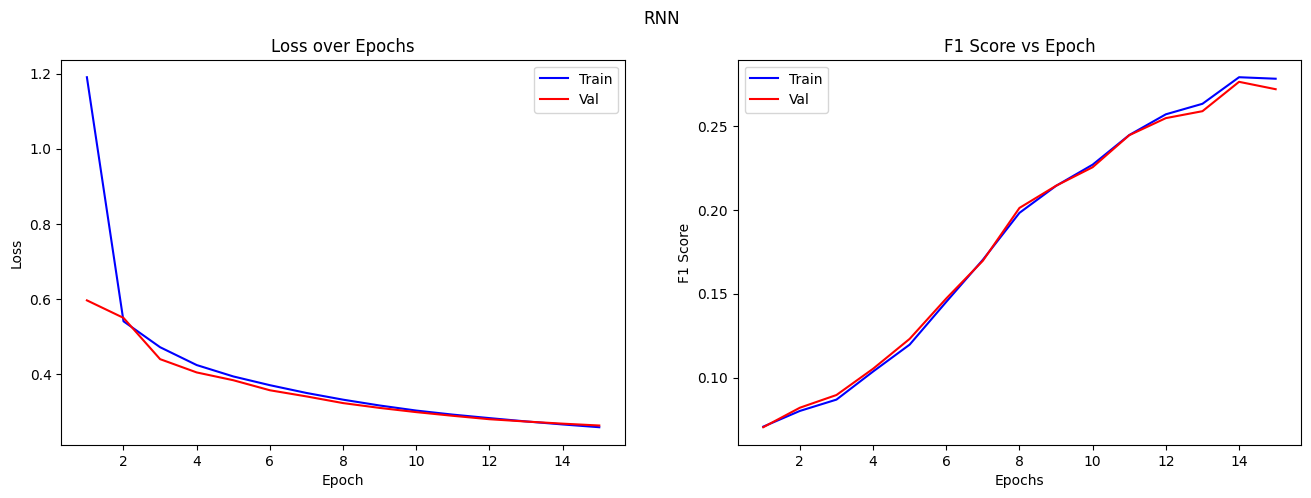

In [22]:
draw_loss_graph(rnn_training,model_name, rnn_f1_callback.train_f1_scores, rnn_f1_callback.val_f1_scores)
save_model(rnn_model,model_name,Embedding_name,Dataset)

### Testing

In [23]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing accuracy

In [24]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

30/30 [==============================] - 1s 5ms/step - loss: 0.2977 - acc: 0.9341 - precision: 0.9510 - recall: 0.9058
0.9340960383415222


Testing F1 Score

In [25]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

30/30 [==============================] - 0s 5ms/step


Test F1 Score: 0.2738595194797


## GRU

In [26]:
model_name="GRU"

### Training

In [27]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(Y_train.shape[2], activation='softmax')))

compiling 

In [28]:
gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])

In [29]:
gru_f1_callback = F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))

In [30]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 300)           9066000   
                                                                 
 gru (GRU)                   (None, 70, 64)            70272     
                                                                 
 time_distributed_1 (TimeDi  (None, 70, 28)            1820      
 stributed)                                                      
                                                                 
Total params: 9138092 (34.86 MB)
Trainable params: 72092 (281.61 KB)
Non-trainable params: 9066000 (34.58 MB)
_________________________________________________________________


Fitting GRU

In [31]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_val, Y_val), callbacks=[gru_f1_callback])

Epoch 1/15


251/251 [==============================] - 2s 8ms/step
Val F1 Score: 0.07514295748597537 - Train F1 Score: 0.07559395378278459
63/63 [==============================] - 27s 395ms/step - loss: 1.7613 - acc: 0.8086 - precision_1: 0.8584 - recall_1: 0.4094 - val_loss: 0.6449 - val_acc: 0.9137 - val_precision_1: 0.9281 - val_recall_1: 0.8335
Epoch 2/15
251/251 [==============================] - 2s 7ms/step
Val F1 Score: 0.08536485230295636 - Train F1 Score: 0.08475255077692799
63/63 [==============================] - 22s 360ms/step - loss: 0.5108 - acc: 0.9175 - precision_1: 0.9338 - recall_1: 0.8558 - val_loss: 0.4555 - val_acc: 0.9213 - val_precision_1: 0.9400 - val_recall_1: 0.8651
Epoch 3/15
251/251 [==============================] - 2s 7ms/step
Val F1 Score: 0.11645887069759371 - Train F1 Score: 0.11494159355875458
63/63 [==============================] - 21s 345ms/step - loss: 0.4252 - acc: 0.9255 - precision_1: 0.9437 - recall_1: 0.8821 - val_loss: 0.4007 - val_acc: 0.9275 - val_prec

Plotting Graph

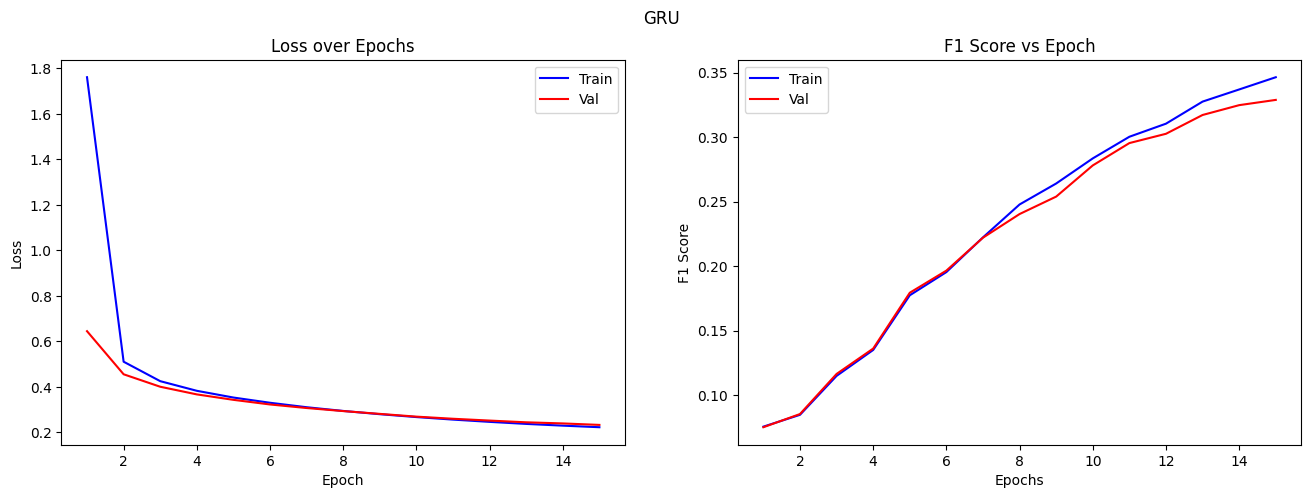

In [32]:
draw_loss_graph(gru_training,model_name, gru_f1_callback.train_f1_scores, gru_f1_callback.val_f1_scores)
save_model(gru_model,model_name,Embedding_name,Dataset)

### Testing

In [33]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing Accuracy

In [34]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

30/30 [==============================] - 1s 11ms/step - loss: 0.2640 - acc: 0.9397 - precision_1: 0.9543 - recall_1: 0.9274
0.9397260546684265


Testing F1 Score

In [35]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

30/30 [==============================] - 1s 7ms/step
Test F1 Score: 0.3312644453184654


# LSTM

In [36]:
model_name="LSTM"

### Training

In [37]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(Y_train.shape[2], activation='softmax')))# Lstm

Compiling LSTM

In [38]:
lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])

In [39]:
LSTM_f1_callback=F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))

In [40]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 70, 300)           9066000   
                                                                 
 lstm (LSTM)                 (None, 70, 64)            93440     
                                                                 
 time_distributed_2 (TimeDi  (None, 70, 28)            1820      
 stributed)                                                      
                                                                 
Total params: 9161260 (34.95 MB)
Trainable params: 95260 (372.11 KB)
Non-trainable params: 9066000 (34.58 MB)
_________________________________________________________________


Fitting LSTM

In [41]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_val, Y_val), callbacks=[LSTM_f1_callback])

Epoch 1/15


251/251 [==============================] - 2s 8ms/step
Val F1 Score: 0.06663109613909377 - Train F1 Score: 0.06680389478835387
63/63 [==============================] - 26s 372ms/step - loss: 1.6536 - acc: 0.7273 - precision_2: 0.8421 - recall_2: 0.4673 - val_loss: 0.7612 - val_acc: 0.9014 - val_precision_2: 0.8954 - val_recall_2: 0.8001
Epoch 2/15
251/251 [==============================] - 2s 8ms/step
Val F1 Score: 0.068779230466286 - Train F1 Score: 0.06935082307819497
63/63 [==============================] - 23s 369ms/step - loss: 0.6405 - acc: 0.9074 - precision_2: 0.9093 - recall_2: 0.8256 - val_loss: 0.5710 - val_acc: 0.9119 - val_precision_2: 0.9195 - val_recall_2: 0.8501
Epoch 3/15
251/251 [==============================] - 2s 7ms/step
Val F1 Score: 0.079174900531034 - Train F1 Score: 0.07945163335626122
63/63 [==============================] - 21s 344ms/step - loss: 0.5301 - acc: 0.9159 - precision_2: 0.9275 - recall_2: 0.8496 - val_loss: 0.4998 - val_acc: 0.9189 - val_precisio

Plotting Graph

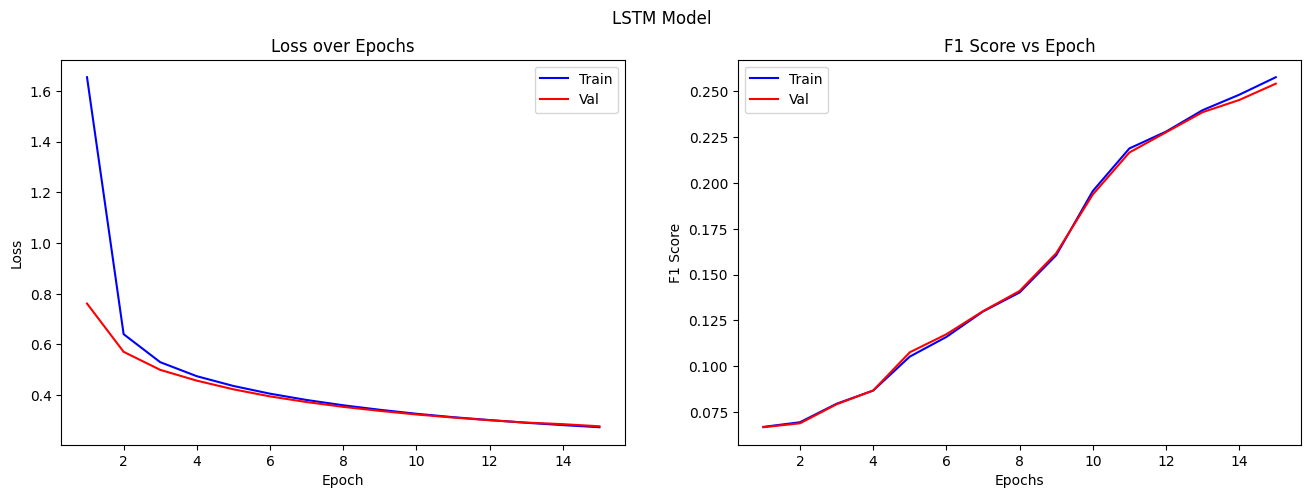

In [42]:
draw_loss_graph(lstm_training, "LSTM Model", LSTM_f1_callback.train_f1_scores, LSTM_f1_callback.val_f1_scores)
save_model(lstm_model, model_name, Embedding_name, Dataset)
loaded_model = load_model(model_name,Embedding_name,Dataset)

### Testing

In [43]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing accuracy

In [44]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

30/30 [==============================] - 1s 9ms/step - loss: 0.3095 - acc: 0.9341 - precision_2: 0.9525 - recall_2: 0.9038
0.9340508580207825


Testing F1 Score

In [45]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

30/30 [==============================] - 1s 8ms/step
Test F1 Score: 0.24340533734784547


# BiLSTM

In [46]:
model_name="BiLSTM"

Training

In [47]:
input=Input(shape=(max_len,))
BiLSTM_CRF_embed=Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[weights], trainable=False)(input)
BiLSTM_CRF_bilstm=Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(BiLSTM_CRF_embed)
BiLSTM_model=(TimeDistributed(Dense(Y_test.shape[2], activation='relu')))(BiLSTM_CRF_bilstm)

crf = CRF(Y_padded_test.shape[2])
predicted_sequence, potentials, sequence_length, crf_kernel = crf(BiLSTM_model)

BiLSTM_model=Model(input,potentials)

Compiling the BiLSTM Model

In [48]:
BiLSTM_model.compile(
        optimizer=AdamW(learning_rate=0.002),
        loss=SigmoidFocalCrossEntropy(),
        metrics=['accuracy']
    )

In [49]:
BiLSTM_f1_callback = F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))

In [50]:
BiLSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 70, 300)           9066000   
                                                                 
 bidirectional (Bidirection  (None, 70, 256)           439296    
 al)                                                             
                                                                 
 time_distributed_3 (TimeDi  (None, 70, 28)            7196      
 stributed)                                                      
                                                                 
 crf (CRF)                   [(None, 70),              1652      
                              (None, 70, 28),                    
                              (None,),                       

Fitting the BiLSTM Model

In [51]:
BiLSTM_training = BiLSTM_model.fit(X_train,Y_train,batch_size=128,epochs=15,validation_data=(X_val,Y_val),callbacks=[BiLSTM_f1_callback])

Epoch 1/15


251/251 [==============================] - 7s 30ms/step
Val F1 Score: 0.06755059619099821 - Train F1 Score: 0.06811021632482964
63/63 [==============================] - 57s 783ms/step - loss: 0.2082 - accuracy: 0.8837 - val_loss: 0.0871 - val_accuracy: 0.9116
Epoch 2/15
251/251 [==============================] - 9s 34ms/step
Val F1 Score: 0.07671036143780963 - Train F1 Score: 0.07538197351921694
63/63 [==============================] - 50s 805ms/step - loss: 0.0715 - accuracy: 0.9197 - val_loss: 0.0663 - val_accuracy: 0.9200
Epoch 3/15
251/251 [==============================] - 8s 32ms/step
Val F1 Score: 0.09199901535015809 - Train F1 Score: 0.0919651197238053
63/63 [==============================] - 48s 761ms/step - loss: 0.0707 - accuracy: 0.9192 - val_loss: 0.0631 - val_accuracy: 0.9265
Epoch 4/15
251/251 [==============================] - 10s 40ms/step
Val F1 Score: 0.09426372210286073 - Train F1 Score: 0.0944059091115984
63/63 [==============================] - 52s 833ms/step - lo

Plotting the graph

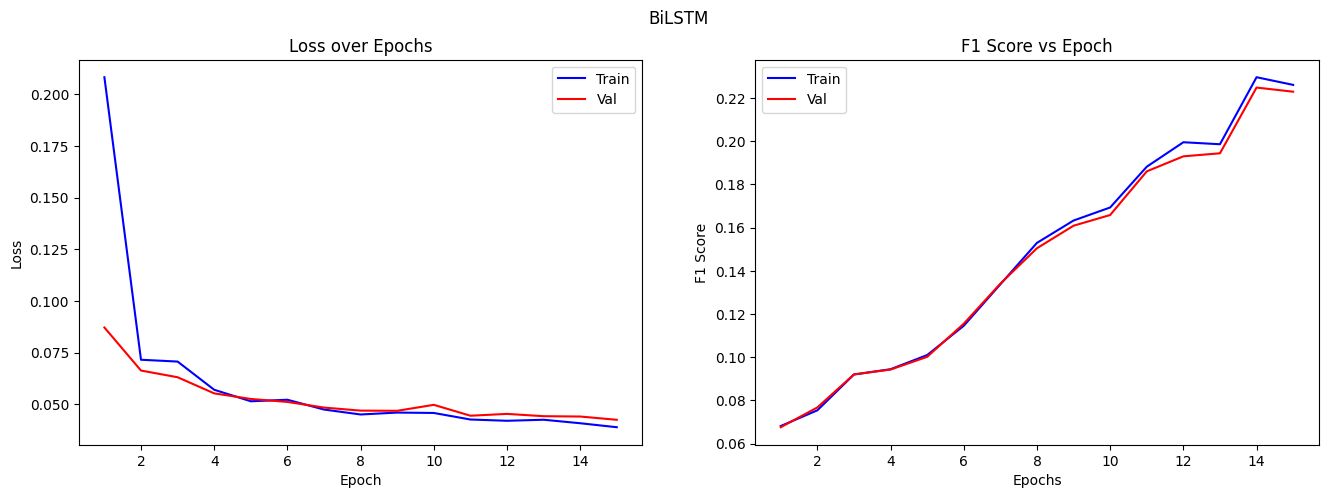

In [52]:
draw_loss_graph(BiLSTM_training,model_name, BiLSTM_f1_callback.train_f1_scores, BiLSTM_f1_callback.val_f1_scores)
save_model(BiLSTM_model,model_name,Embedding_name,Dataset)

## Testing 

In [53]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing accuracy

In [54]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

30/30 [==============================] - 3s 37ms/step - loss: 0.0501 - accuracy: 0.9327
0.932711124420166


Testing F1 Score

In [55]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

30/30 [==============================] - 2s 36ms/step
Test F1 Score: 0.22636657481400224
